# River current estimation using drone video
This notebook shows the computation of flow fields based on drone images. The Drone images were collected during a high discharge event on january 24th 2018. The images were created by a DJI phantom drone by "AUTHOR" and provided to the quick reaction force. 

One of the challenges is to measure a spatial variation in waves, currents and flood extent. In this notebook we'll analyse "shape changes". We don't focus on one particular process but try to capture a combined signal that can include waves, changes of flood extent, object/shape velocities. The data is intended for use in a bayesian or deep learning framework that can seperate the different processes based on conditional probabilities. For example given a known wave speed of 1m/s and non-moving waves based on this estimate, we can increase the a-posteriori probability of current speeds of -1m/s. 

In [1]:
# we start by including some modules
import pathlib
# looping without using much memory
import itertools 

# computations
import numpy as np 
# video analysis
import cv2
# plotting
import matplotlib.pyplot as plt
import matplotlib.colors
# colormaps
import matplotlib.cm
import cmocean.cm
# some notebook widgets
import tqdm
import IPython.display


In [2]:
# choose one of these two input files
source = pathlib.Path('~/data/drone/DJI_0044.mov').expanduser()
source = pathlib.Path('~/data/drone/DJI_0008....mp4').expanduser()
# define a slice of interest
s = np.s_[100:-100:2, ::2]

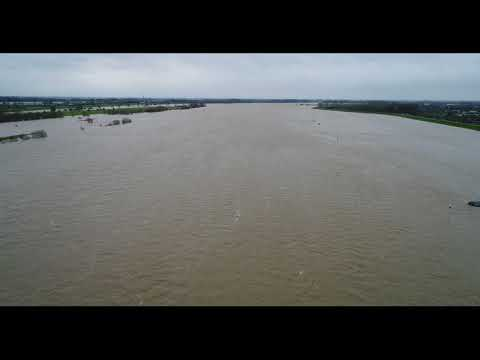

In [3]:
# this shows the 0008 video. 
# It is taken from a nice angle
IPython.display.YouTubeVideo('Xr3sEF-Oc_8')

In [4]:
# capture video into an opencv video stream
cap = cv2.VideoCapture(str(source))

We now have the video in memory, in the for of a stream. We will process the video in pairs. There are other techniques that can be used. If there is a lot of debris floating around you can use a regular feature based technique, similar to PIV. A good technique for feature-based optical flow is the Lucas-Kanade method. 

In this case however there are no "good features", which requires the use of a different method, the technique known as "dense optical flow". In this case we'll use the Farneback algorithm. 


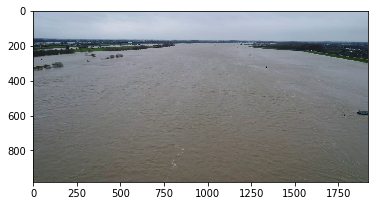

In [5]:
status, img = cap.read()
# slice and convert from BGR to RGB
img = img[s][..., ::-1]
fig, ax = plt.subplots()
# show BGR img as RGB
ax.imshow(img)

In [6]:
def framepairs(n=10, s=None):
    """yield gray framepairs, by sliced by optional s"""
    if s is None:
        s = np.s_[:, :]
    status, img0 = cap.read()
    if not status == True:
        raise StopIteration()
    for i in range(n):
        status, img1 = cap.read()
        if not status == True:
            break
        gray0 = cv2.cvtColor(img0[s], cv2.COLOR_BGR2GRAY)
        gray1 = cv2.cvtColor(img1[s], cv2.COLOR_BGR2GRAY)
        yield gray0, gray1
        img0, img1 = img1, None

def warp_flow(img, flow):
    """apply a flow field to an image (from opt_flow.py in opencv)"""
    h, w = flow.shape[:2]
    flow = -flow
    flow[:, :, 0] += np.arange(w)
    flow[:, :, 1] += np.arange(h)[:, np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res        
        

In [7]:
# we just have few frames, store everything in memory
flows = []
grays = []
# slice in half, skip the top part, there are some black margins
for gray0, gray1 in framepairs(n=100, s=s):
    # compute flow
    flow = cv2.calcOpticalFlowFarneback(gray0, gray1, None, 0.5, 5, 10, 3, 5, 1.1, 0)
    # keep
    flows.append(flow[np.newaxis, ...])
    # keep current image
    grays.append(gray0)
# convert to array
flows = np.concatenate(flows, axis=0)

We now have a series of flow field we can plot that using different techniques. Here we used map the direction to a perceptual uniform direction and magnitude. This allows us to see if the flow field is uniform in direction

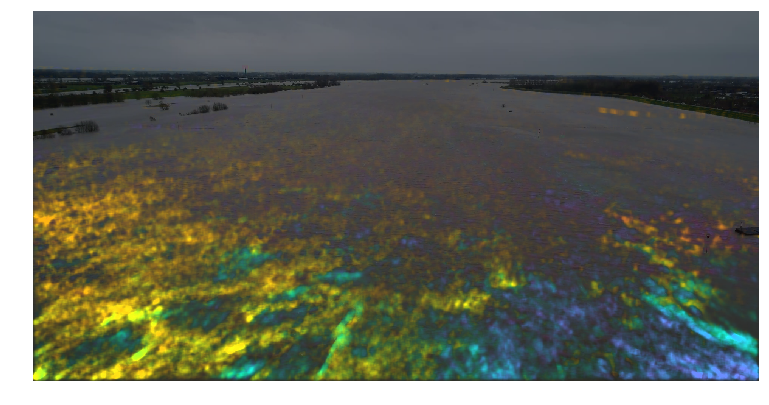

In [17]:
# show the average flow
# Scale velocities to 0.3 px/s -> full intensity
N = matplotlib.colors.Normalize(vmin=0, vmax=0.3, clip=True)
# compute the mean flow
flow = flows.mean(axis=0)
# convert magitude and angle
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
# transform angle into color, drop the alpha channel
rgb = cmocean.cm.phase(ang / (np.pi * 2))[:, :, :3]
# convert to hsv
hsv = matplotlib.colors.rgb_to_hsv(rgb)
# use the magnitude as value 
hsv[..., 2] = N(mag)
# convert back to rgb
rgb = matplotlib.colors.hsv_to_rgb(hsv)
rgba = np.dstack([rgb, N(mag)[..., np.newaxis] * 0.5 + 0.5])
# show the result
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(img)
ax.imshow(rgba)
ax.axis('off');


We also show the flow field using image based flow advection. Dye is poored into an image every 100px. It is advected using the flow field. This process is repeated for each timestep and using the time dependent flow. This is like an oil trace from a leaking ship. 

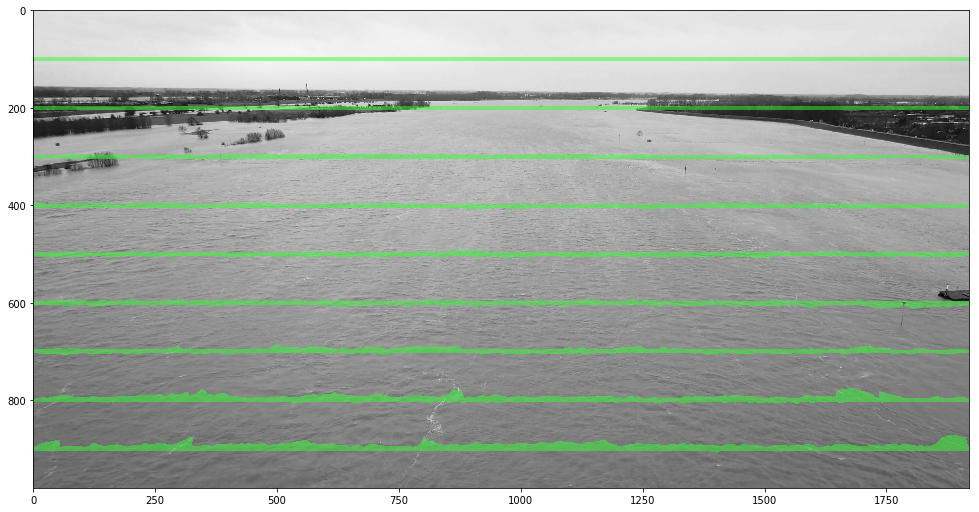

In [10]:
# generate a colormap with transparency
greens_alpha = matplotlib.colors.ListedColormap([
    [0.2,1,0.2,0.0], 
    [0.2,1,0.2, 1.0]
])

# generate a plot without too much whitespace
fig, ax = plt.subplots(figsize=(13, 8))
fig.tight_layout()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

# initial paint
paint = np.zeros_like(gray0, dtype='float32').copy()

# keep plot elements so we can update data
im_gray = ax.imshow(gray0, cmap='Greys_r')
im_paint = ax.imshow(paint, cmap=greens_alpha, alpha=0.5, vmax=1, vmin=0)
for i, UV in enumerate(flows):
    # keep pooring in dye
    for y in range(100, flows.shape[1], 100):
        # It only paints if you pass a value > 0.5/128
        # alpha painting is not working
        cv2.line(paint, (0, y), (flows.shape[2], y), (1, ), 5)

    # advect
    paint = warp_flow(paint, UV)
    # update
    im_gray.set_data(grays[i])
    im_paint.set_data(paint)
# save the final image
fig.savefig('river-profiles.png')